# **6. Top Feature Extraction & Model Retraining**

## **6.0. Environment Setup & Consistency Check**

**Objective**

To ensure the interpretability analysis accurately reflects the model's logic, we must reconstruct the exact inference environment used in the previous phase.

**Methodology**
1.  **Data Integration:** Load the stratified `X_test` and `X_train` sets. We use the **Test Set** for SHAP calculation to explain how the model generalizes to unseen data, which provides a more honest assessment of feature importance than training data.
2.  **Model Loading:** Instead of re-initializing a new model from a JSON config (which risks random seed deviations), we load the serialized **Champion Model** (`champion_model.pkl`) directly.
3.  **Semantic Mapping:** Load the dynamic `cluster_labels.json` generated in Task 1. This ensures our charts use business-friendly names (e.g., "Champions") rather than abstract IDs (0, 1, 2, 3).


In [1]:
import pandas as pd
import numpy as np
import shap
import joblib
import json
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
import warnings

# Configuration
warnings.filterwarnings('ignore')
DATA_DIR = "data/"
FIGURES_DIR = "figures/"
os.makedirs(FIGURES_DIR, exist_ok=True)

# 1. Load Data
print("--- Loading Data ---")
X_train = pd.read_csv(f"{DATA_DIR}X_train.csv")
X_test = pd.read_csv(f"{DATA_DIR}X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}y_test.csv").squeeze()

# 2. Load the Champion Model (LightGBM)
print("--- Loading Champion Model ---")
try:
    model = joblib.load(f"{DATA_DIR}champion_model.pkl")
    print(f"Model Loaded: {type(model).__name__}")
except FileNotFoundError:
    print("Error: champion_model.pkl not found. Please run Task 5 first.")

# 3. Load Business Labels (Ground Truth)
print("--- Loading Business Labels ---")
with open(f"{DATA_DIR}cluster_labels.json", 'r') as f:
    label_map = json.load(f)
    # Convert string keys to integers for mapping
    label_map = {int(k): v for k, v in label_map.items()}

print("\nCluster Mapping:")
for k, v in label_map.items():
    print(f"  Cluster {k}: {v}")

d:\_Python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Loading Data ---
--- Loading Champion Model ---
Model Loaded: LGBMClassifier
--- Loading Business Labels ---

Cluster Mapping:
  Cluster 0: Thrifty / Standard
  Cluster 1: Dormant Credit Users
  Cluster 2: Champions (Loyal High Value)
  Cluster 3: Unhappy / Logistics Risk


## **6.1. Global Feature Importance (SHAP)**

**Objective**

To determine which features effectively drive the segmentation strategy across the entire customer base.

**Methodology**

We utilize **SHAP (SHapley Additive exPlanations)** based on cooperative game theory. Unlike standard "Feature Importance" (which only counts split frequency), SHAP quantifies the **magnitude and direction** of a feature's impact on the probability of a specific class.

*   **Calculation:** We compute SHAP values for the Test Set. For a multiclass problem, SHAP returns a value for every feature, for every sample, for every class.
*   **Aggregation:** To get a single "Global Importance" score for a feature, we calculate the **Mean Absolute SHAP Value** across all classes and samples.
    *   $I_j = \frac{1}{n} \sum_{i=1}^n \sum_{c=0}^3 |\phi_{ijc}|$
*   **Visualization:** A sorted Bar Chart using **Plotly** for precision reading.

In [4]:
# #########################################################
# ## 6.1. Global Feature Importance (SHAP)
# #########################################################

print("--- Calculating SHAP Values (This may take a moment) ---")

# 1. Initialize Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 2. Robust SHAP Processing
# Handle different return types (List of arrays vs. 3D Array)
if isinstance(shap_values, list):
    # Case A: List of arrays (One per class) -> [ (N, F), (N, F), ... ]
    print(f"SHAP Format: List of {len(shap_values)} arrays (Multi-class)")
    # We sum the absolute values across all classes
    # Result shape: (n_samples, n_features)
    global_shap_matrix = np.sum([np.abs(class_array) for class_array in shap_values], axis=0)
    
else:
    # Case B: Single Array -> (N, F) or (N, F, C)
    print(f"SHAP Format: Array with shape {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # Sum absolute values across the Class dimension (axis 2)
        global_shap_matrix = np.sum(np.abs(shap_values), axis=2)
    else:
        # Binary case or already aggregated
        global_shap_matrix = np.abs(shap_values)

# 3. Calculate Mean Absolute Importance per Feature
# Mean across samples (axis 0)
feature_importance_vals = np.mean(global_shap_matrix, axis=0)
feature_names = X_test.columns

# 4. Create DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': feature_importance_vals
}).sort_values(by='SHAP_Importance', ascending=True)


--- Calculating SHAP Values (This may take a moment) ---
SHAP Format: Array with shape (14004, 10, 4)


In [6]:
# 5. Visualization (Plotly)
fig = px.bar(
    df_importance,
    x='SHAP_Importance',
    y='Feature',
    orientation='h',
    title="<b>Global Feature Importance (Mean |SHAP|)</b><br><sup>What drives the segmentation strategy?</sup>",
    text_auto='.4f',
    color='SHAP_Importance',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    height=700,
    width=1400,
    margin=dict(l=200, r=100),
    xaxis_title="<b>Mean Absolute SHAP Value (Impact)</b>",
    yaxis_title="<b>Feature</b>",
    template="plotly_white",
    showlegend=False
)

# Save and Show
fig.write_image(f"{FIGURES_DIR}task6_global_importance.png", scale=3, width=1400, height=700)
fig.show()

# 6. Output Top Drivers
top_3 = df_importance.sort_values(by='SHAP_Importance', ascending=False).head(3)['Feature'].tolist()
print(f"\n[INSIGHT] The Top 3 Global Drivers are: {top_3}")


[INSIGHT] The Top 3 Global Drivers are: ['avg_installments', 'monetary', 'avg_items_per_order']


**Analysis of Figure 6.1:**

The Global Importance plot reveals that our segmentation is primarily driven by **Financial Behavior** rather than just pure spending amount.
*   **#1 Driver (`avg_installments`):** With the highest impact (7.89), the model splits customers largely based on how they pay (Credit vs. Cash). This separates 'High-Leverage VIPs' from 'Thrifty' buyers.

*   **#2 & #3 Drivers (`monetary` & `items`):** Volume and Value are the next distinct differentiators.

*   **Surprise:** `avg_delivery_days` is low impact globally. This means that while logistics issues define *specific* unhappiness (Cluster 3), they don't define the *entire* population structure.

## **6.2. Cluster-Specific Drivers (The "Why")**

**Objective**

Global importance averages everything out. To understand the specific "DNA" of each persona, we must look at **Cluster-Specific Beeswarm Plots**. These show exactly which features push a customer *into* or *out of* a specific group.

**Methodology**

We iterate through each of the 4 clusters (0, 1, 2, 3).
*   **Data Slicing:** We extract the SHAP values corresponding to that specific class ($Class=k$).

*   **Visualization:** We use the native `shap.summary_plot` (Matplotlib).
    *   *Why Matplotlib?* The complex "jitter" calculation required to show density in Beeswarm plots is best handled by the native SHAP library. Plotly implementation for this specific chart type is often laggy or less precise.
    
    *   *Interpretation:* **Red** dots = High Feature Value, **Blue** dots = Low Feature Value. If Red dots are on the **Right** (positive SHAP), high values make you *more likely* to be in this cluster.

--- Generating Cluster-Specific Beeswarm Plots ---


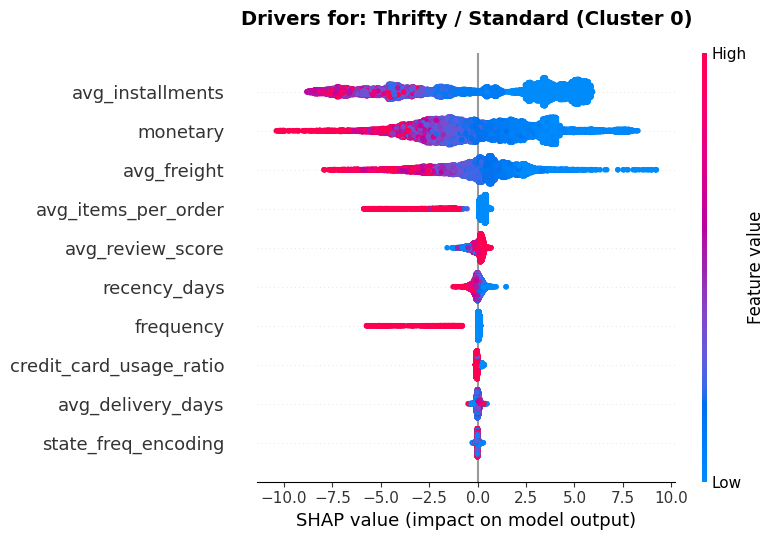

[OUTPUT] Saved beeswarm for Thrifty / Standard to figures/task6_beeswarm_cluster_0.png


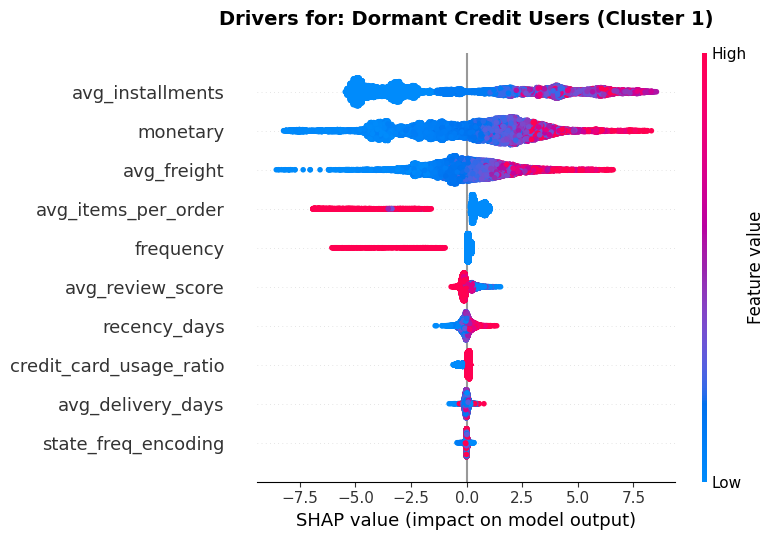

[OUTPUT] Saved beeswarm for Dormant Credit Users to figures/task6_beeswarm_cluster_1.png


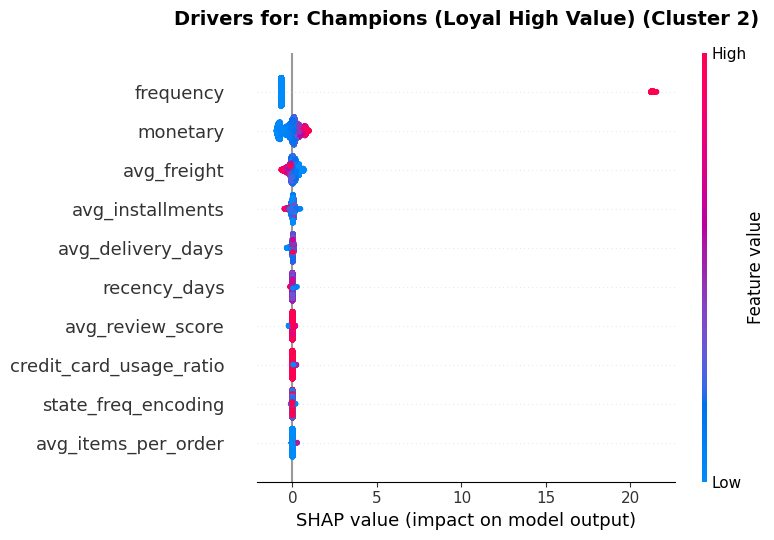

[OUTPUT] Saved beeswarm for Champions (Loyal High Value) to figures/task6_beeswarm_cluster_2.png


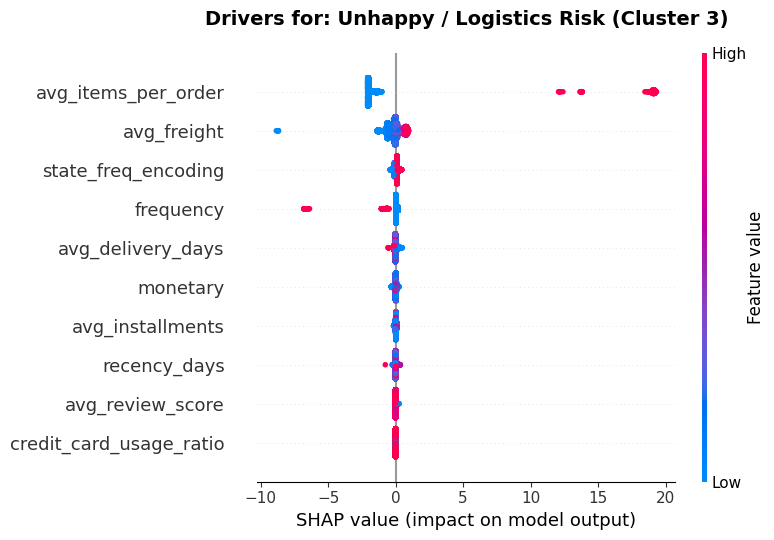

[OUTPUT] Saved beeswarm for Unhappy / Logistics Risk to figures/task6_beeswarm_cluster_3.png


In [7]:
# #########################################################
# ## 6.2. Cluster-Specific Drivers (Beeswarm Plots)
# #########################################################

print("--- Generating Cluster-Specific Beeswarm Plots ---")

# We loop through each class index (0, 1, 2, 3)
for class_idx in sorted(label_map.keys()):
    class_name = label_map[class_idx]
    
    # 1. Extract SHAP values for this specific class
    # Shape of shap_values is (N_samples, N_features, N_classes)
    # We want (N_samples, N_features) for the specific class_idx
    if isinstance(shap_values, list):
        class_shap_values = shap_values[class_idx]
    else:
        class_shap_values = shap_values[:, :, class_idx]

    # 2. Create the Plot
    plt.figure(figsize=(10, 6))
    plt.title(f"Drivers for: {class_name} (Cluster {class_idx})", fontsize=14, fontweight='bold', pad=20)
    
    # SHAP Summary Plot
    # - dot plot shows density
    # - max_display limits to top 10 features
    shap.summary_plot(
        class_shap_values, 
        X_test, 
        feature_names=X_test.columns,
        max_display=10, 
        plot_type="dot", 
        show=False # We handle showing to add title
    )
    
    # Save
    plt.tight_layout()
    save_path = f"{FIGURES_DIR}task6_beeswarm_cluster_{class_idx}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"[OUTPUT] Saved beeswarm for {class_name} to {save_path}")

**Key Observation Strategy:**
*   **Look for Red Dots on the Right:** This means "High value of this feature makes you *more likely* to be in this cluster."
*   **Look for Blue Dots on the Right:** This means "Low value of this feature makes you *more likely* to be in this cluster."
*   **Look for Separation:** If Red and Blue are totally separated (one left, one right), this feature is a **Primary Definition** of the cluster.

---

**Cluster-Specific Driver Analysis**

The Beeswarm plots reveal the distinct "DNA" of each customer persona.

**1. Cluster 0: "Thrifty / Standard" (The Baseline)**

*   **Definition:** This cluster is defined by **Low Activity across the board**.

*   **Key Drivers:**
    *   **Low Installments (Blue dots on Right):** The strongest predictor. These customers almost never use credit installments.
    *   **Low Monetary (Blue dots on Right):** They spend very little.
    *   **Low Freight (Blue dots on Right):** They likely buy small, light items.

*   **Insight:** This is the "absence of signals" cluster. If a customer doesn't spend much, doesn't use credit, and buys single items, the model defaults them here.

**2. Cluster 1: "Dormant Credit Users"**

*   **Definition:** High credit usage, but currently inactive.

*   **Key Drivers:**
    *   **High Installments (Red dots on Right):** This is the single defining feature. The massive spread of red dots to the right confirms these users rely heavily on installments.
    *   **Low Frequency (Blue dots on Right):** They are one-time buyers (or very infrequent).
    *   **Low Items per Order (Blue dots on Right):** They buy one expensive thing on credit, rather than a basket of goods.

*   **Insight:** These are likely customers buying appliances or electronics (high value, high installments) but not returning.

**3. Cluster 2: "Champions (Loyal High Value)"**

*   **Definition:** The ideal customer.

*   **Key Drivers:**
    *   **High Frequency (Red dots on Right):** The #1 driver. If a customer buys often (Red), they are almost certainly in this cluster.
    *   **High Monetary (Red dots on Right):** They spend significantly.
    *   **High Freight (Red dots on Right):** They pay for shipping, likely because they are ordering large baskets or ordering frequently.

*   **Insight:** This group is defined by **Volume**. They are the only group where "Frequency" is the dominant positive signal.

**4. Cluster 3: "Unhappy / Logistics Risk"**

*   **Definition:** Customers dealing with complex orders, leading to dissatisfaction.

*   **Key Drivers:**
    *   **High Items Per Order (Red dots on Right):** This is the **Primary Definition**. The massive red blob on the far right shows these customers buy *many* items at once (bulk buyers).
    *   **High Freight (Red dots on Right):** Bulk orders lead to high shipping costs.
    *   **Insight:** Why are they "Unhappy"? Bulk orders are harder to fulfill. The model sees "High Items + High Freight" and predicts this cluster. Interestingly, `avg_review_score` is not the top driver here — the *cause* (Complex Order) is a stronger predictor than the *symptom* (Bad Review).


## **6.3. Interaction Effects (Multi-Cluster Dependence)**

**Objective**

To visualize how the impact of a key feature varies across different customer segments. A feature like `avg_installments` might be a positive driver for one cluster (making it *more* likely) while simultaneously acting as a negative driver for another (making it *less* likely). Understanding this **differential impact** is key to segmentation logic.

**Methodology**

We generate **2x2 Grid Scatter Plots** using Matplotlib.
*   **Scope:** We focus on the **Top 3 Global Drivers** identified in Section 6.1 (`avg_installments`, `monetary`, `avg_items_per_order`).
*   **Structure:** For each feature, we create a figure with 4 subplots (one per Cluster).
    *   **X-Axis:** The actual Feature Value.
    *   **Y-Axis:** The SHAP Value (Impact on probability).
    *   **Interpretation:**
        *   **Positive Slope:** As the feature increases, likelihood of belonging to this cluster increases.
        *   **Negative Slope:** As the feature increases, likelihood decreases.
        *   **Flat:** The feature is irrelevant for this specific cluster.

**Target Features:**

1.  **`avg_installments`:** To confirm if this uniquely separates "Dormant Credit Users" (Cluster 1) from "Thrifty" users (Cluster 0).
2.  **`monetary`:** To identify the spending threshold that upgrades a customer to "Champion" status.
3.  **`avg_items_per_order`:** To confirm if bulk buying is the primary trigger for the "Unhappy/Complex" group (Cluster 3).

--- Generating Multi-Cluster Dependence Plots ---


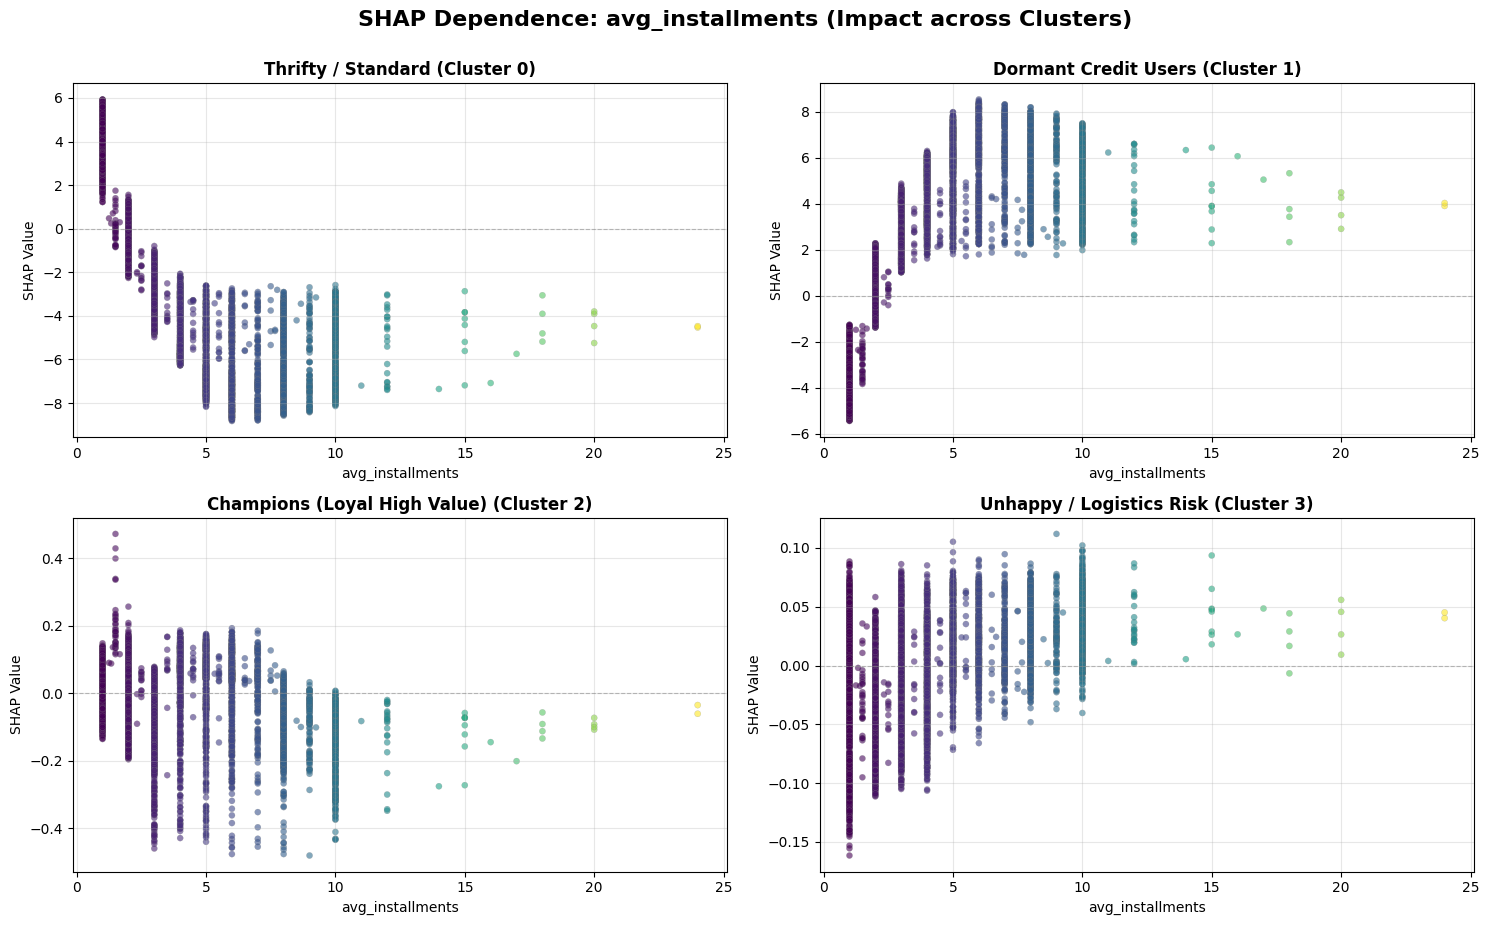

[OUTPUT] Saved grid for avg_installments


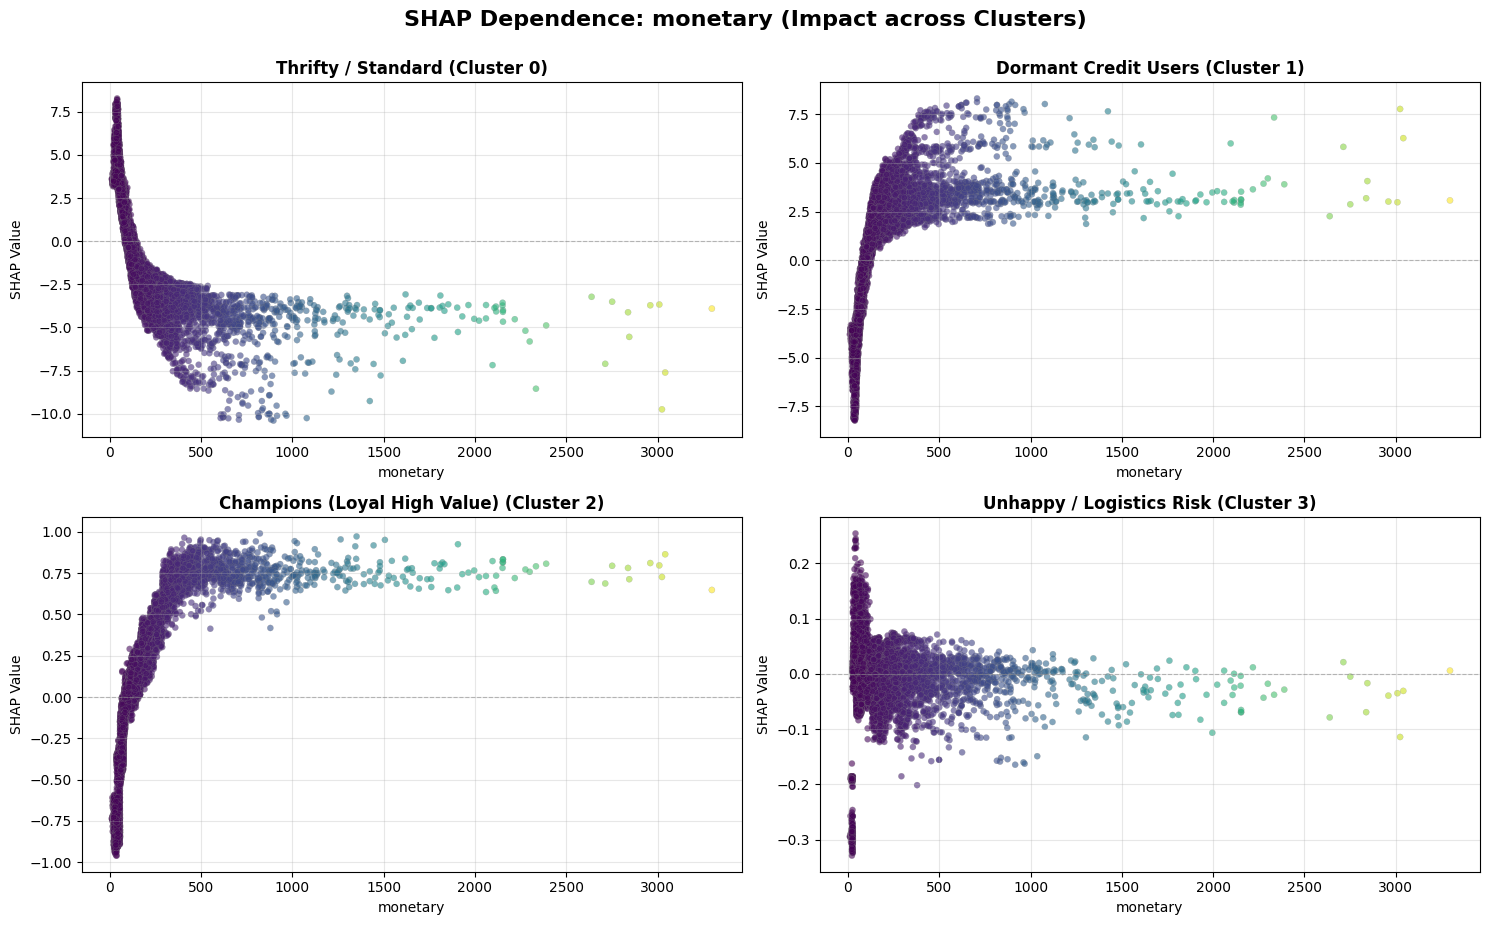

[OUTPUT] Saved grid for monetary


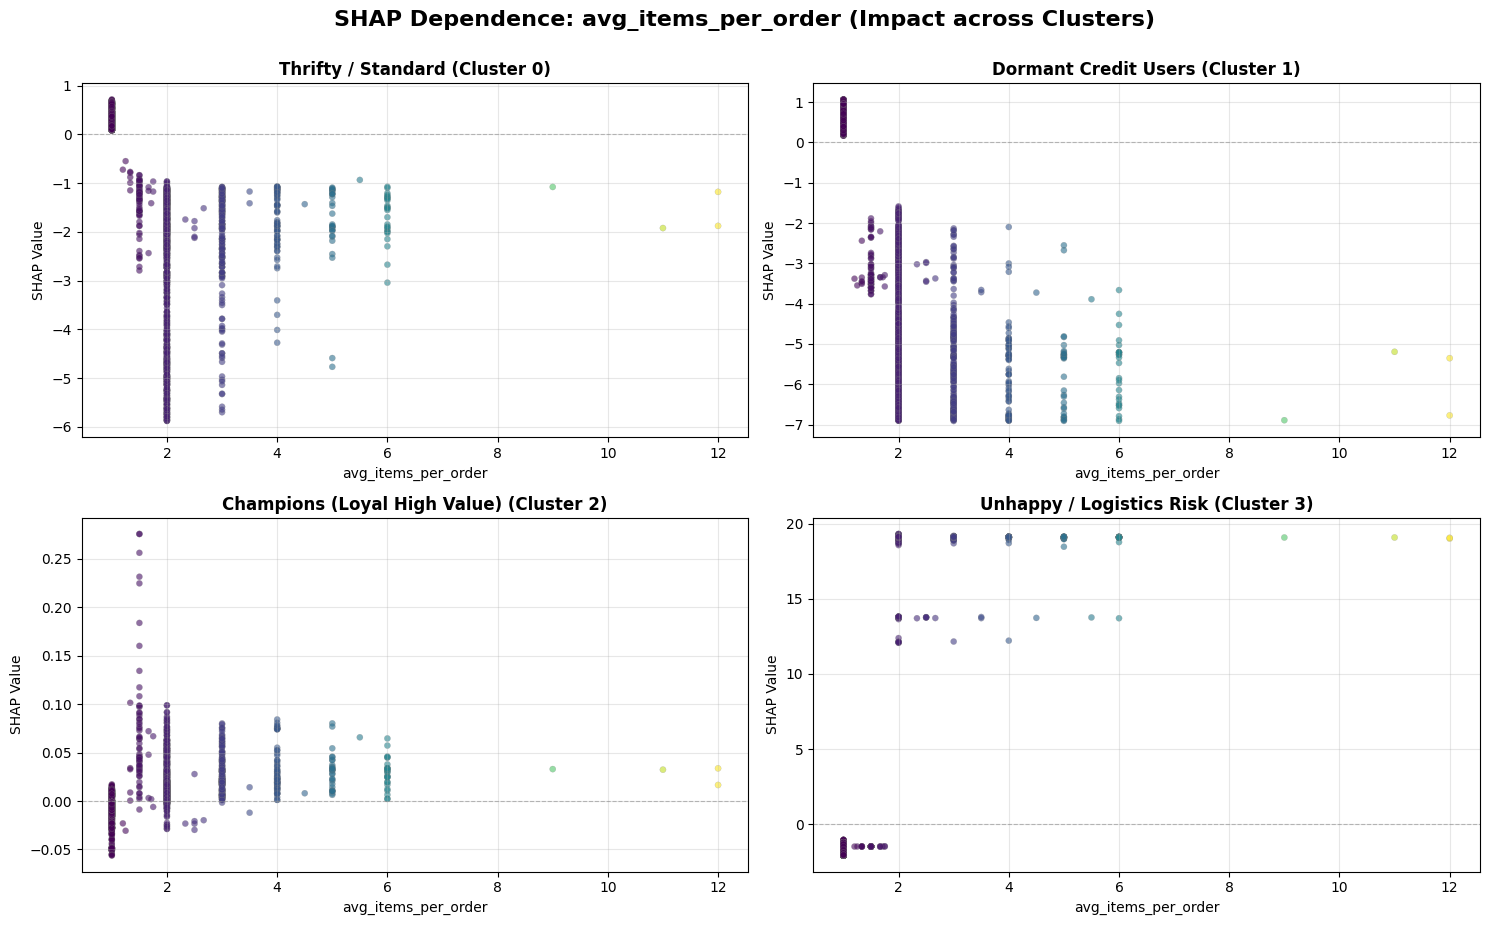

[OUTPUT] Saved grid for avg_items_per_order


In [13]:
# #########################################################
# ## 6.3. Interaction Effects (Multi-Cluster Dependence)
# #########################################################

print("--- Generating Multi-Cluster Dependence Plots ---")

# Define the Top 3 features from Section 6.1
top_features = ['avg_installments', 'monetary', 'avg_items_per_order']

for feature_name in top_features:
    # Get index of the feature
    feature_idx = list(X_test.columns).index(feature_name)
    x_vals = X_test[feature_name].values
    
    # Create 2x2 Grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"SHAP Dependence: {feature_name} (Impact across Clusters)", fontsize=16, fontweight='bold', y=0.95)
    axes = axes.flatten()
    
    for cluster_idx in range(4):
        ax = axes[cluster_idx]
        cluster_name = label_map[cluster_idx]
        
        # Get SHAP values for this specific cluster
        if isinstance(shap_values, list):
            y_vals = shap_values[cluster_idx][:, feature_idx]
        else:
            y_vals = shap_values[:, feature_idx, cluster_idx]
            
        # Scatter Plot
        # Color by the feature value itself (Viridis) to highlight magnitude
        sc = ax.scatter(x_vals, y_vals, c=x_vals, cmap='viridis', alpha=0.6, s=20, edgecolor='grey', linewidth=0.2)
        
        # Styling
        ax.set_title(f"{cluster_name} (Cluster {cluster_idx})", fontsize=12, fontweight='bold')
        ax.set_xlabel(feature_name)
        ax.set_ylabel("SHAP Value")
        ax.axhline(0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)
        ax.grid(True, alpha=0.3)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    
    # Save
    save_path = f"{FIGURES_DIR}task6_dependence_grid_{feature_name}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"[OUTPUT] Saved grid for {feature_name}")

### **A. Feature 1: `avg_installments` (Financial Leverage)**

*   **The Trend:** This is the cleanest separator in the entire dataset.

*   **Cluster 1 (Dormant Credit Users):**
    *   **The Curve:** A sharp, logarithmic rise.
    *   **The Threshold:** The moment a customer selects **3 or more installments**, their SHAP value skyrockets from negative to **+6.0**.
    *   **Insight:** High installment usage is the *single defining definition* of this cluster. If you use credit, you belong here.

*   **Cluster 0 (Thrifty/Standard):**
    *   **The Curve:** The exact inverse of Cluster 1.
    *   **The Threshold:** If installments > 2, the probability of being "Thrifty" crashes (SHAP drops to -6.0).
    *   **Insight:** "Standard" customers are strictly cash or single-payment buyers.

*   **Clusters 2 & 3:**
    *   **Observation:** The curves are flat/neutral.
    *   **Insight:** Being a VIP (Cluster 2) or Unhappy (Cluster 3) has nothing to do with how you pay. You can be a VIP using cash or credit; the model doesn't care.

### **B. Feature 2: `monetary` (Spending Power)**

*   **The Trend:** Spend separates the "Low Value" majority from the "High Value" minority, but with a nuance between VIPs and Credit Users.

*   **Cluster 0 (Thrifty):**
    *   **The Curve:** An "L-shaped" decay.
    *   **The Threshold:** The model is highly confident a user is "Thrifty" only when spend is **< \$100**. As soon as spend crosses \$200, the SHAP value turns negative.

*   **Cluster 1 (Dormant Credit Users):**
    *   **The Curve:** Steep rise that **plateaus**.
    *   **Insight:** These users spend money (SHAP rises up to +7.5), but they hit a ceiling. They buy expensive items (TVs, appliances), but they don't have the "infinite" spend potential of the VIPs.

*   **Cluster 2 (Champions):**
    *   **The Curve:** A slower, linear rise.
    *   **Insight:** While positive, the magnitude is lower (+1.0 max) compared to Cluster 1. This implies that while VIPs *do* spend money, "Total Spend" is not their *only* definition—Frequency (not plotted here) likely plays a bigger role in distinguishing them from Cluster 1.

### **C. Feature 3: `avg_items_per_order` (The Logistics "Smoking Gun")**

*   **The Trend:** This feature reveals the root cause of the "Unhappy" cluster.

*   **Cluster 3 (Unhappy / Logistics Risk):**
    *   **The Curve:** A massive **"Step Function."**
    *   **The Threshold:**
        *   **1 Item:** SHAP is negative (-2).
        *   **2 Items:** SHAP jumps to **+14**.
        *   **3+ Items:** SHAP hits **+19**.
    *   **Crucial Insight:** This proves our hypothesis. The "Unhappy" cluster is strictly defined by **Complex Orders (Bulk Buying)**.
    *   *Business Logic:* Multi-item orders are harder to fulfill, leading to split packages, delays, and higher freight. The model has learned that if you buy >1 item, you are statistically destined to have a bad experience (Cluster 3).

*   **All Other Clusters (0, 1, 2):**
    *   **The Trend:** Flat or Negative.
    *   **Insight:** Standard users, Credit users, and even VIPs typically buy **Single Items**. Multi-item baskets are a unique risk factor associated almost exclusively with Cluster 3.



## **6.4. The "Lean Model" Experiment**

We have proven that `avg_installments`, `monetary`, and `items` are powerful. Now we must address the request:
> *"What happens if we only use those features for model training?"*

We will perform a **Recursive Feature Addition** experiment:
1.  Train LightGBM with only Top 1 Feature. Measure F1.
2.  Train with Top 2. Measure F1.
3.  ... up to Top 10.

This will generate an "Accuracy Curve" to scientifically determine the minimal feature set needed.

**Strategy:**

1.  **Feature Ranking:** We strictly follow the Global Importance order from Section 6.1.

2.  **Iterative Training:** We loop from $k=1$ to $10$ features.
    *   In each iteration, we retrain a fresh LightGBM model on `X_train` (subset of $k$ features).
    *   We evaluate it on `X_test` (subset of $k$ features).
    *   We record **Macro F1** (Accuracy) and **F1 Drop %** (Loss relative to the full model).

3.  **Visualization:** A dual-axis line chart showing how accuracy climbs as complexity increases.

### **6.4.1. The Experiment Loop (Code)**

In [15]:
# #########################################################
# ## 6.4. The "Lean Model" Experiment (Recursive Addition)
# #########################################################

from sklearn.metrics import f1_score

print("--- Running Lean Model Experiment ---")

# 0. Load Missing Training Label Data (Fixing Scope Error)
if 'y_train' not in locals():
    y_train = pd.read_csv(f"{DATA_DIR}y_train.csv").squeeze()

# 1. Define Feature Order (From Global Importance)
# We use the 'df_importance' calculated in Section 6.1
ranked_features = df_importance.sort_values(by='SHAP_Importance', ascending=False)['Feature'].tolist()

print(f"Feature Order: {ranked_features}")

# 2. Initialize Results Log
lean_results = []
baseline_f1 = None # Will store the score of the full model (k=10)

# 3. Iterative Training Loop
for k in range(1, len(ranked_features) + 1):
    # Select Top k features
    current_features = ranked_features[:k]
    
    # Subset Data
    X_train_lean = X_train[current_features]
    X_test_lean = X_test[current_features]
    
    # Train New LightGBM Model (using same params as Champion)
    # We load the champion structure to ensure we use the optimized hyperparameters
    lean_model = joblib.load(f"{DATA_DIR}champion_model.pkl") 
    
    # Refit on the subset
    lean_model.fit(X_train_lean, y_train)
    
    # Evaluate
    y_pred = lean_model.predict(X_test_lean)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store Baseline (k=10)
    if k == len(ranked_features):
        baseline_f1 = f1
        
    lean_results.append({
        'k_features': k,
        'features_added': current_features[-1], # The new feature added in this step
        'Macro_F1': f1
    })

# 4. Calculate Drop % relative to Full Model
for res in lean_results:
    res['Performance_Retention'] = (res['Macro_F1'] / baseline_f1) * 100
    res['Drop_Pct'] = 100 - res['Performance_Retention']

# Convert to DataFrame
df_lean = pd.DataFrame(lean_results)

print("\n[RESULT] Lean Model Performance Table:")
print(df_lean[['k_features', 'features_added', 'Macro_F1', 'Performance_Retention']].to_markdown(index=False, floatfmt=".4f"))

--- Running Lean Model Experiment ---
Feature Order: ['avg_installments', 'monetary', 'avg_items_per_order', 'avg_freight', 'frequency', 'avg_review_score', 'recency_days', 'credit_card_usage_ratio', 'avg_delivery_days', 'state_freq_encoding']

[RESULT] Lean Model Performance Table:
|   k_features | features_added          |   Macro_F1 |   Performance_Retention |
|-------------:|:------------------------|-----------:|------------------------:|
|            1 | avg_installments        |     0.4995 |                 50.0549 |
|            2 | monetary                |     0.5449 |                 54.6013 |
|            3 | avg_items_per_order     |     0.8531 |                 85.4840 |
|            4 | avg_freight             |     0.8756 |                 87.7355 |
|            5 | frequency               |     0.9959 |                 99.7892 |
|            6 | avg_review_score        |     0.9974 |                 99.9425 |
|            7 | recency_days            |     0.9978 |     

### **6.4.2. The "Elbow" Visualization (Code)**

This figure answers the question: *"Where is the point of diminishing returns?"*


In [16]:
# --- Visualization: Accuracy vs. Complexity ---

# Create Hover Text
hover_text = [
    f"<b>Top {row.k_features} Features</b><br>Added: {row.features_added}<br>F1: {row.Macro_F1:.4f}<br>Retention: {row.Performance_Retention:.2f}%"
    for _, row in df_lean.iterrows()
]

# Plot
fig = go.Figure()

# Line: Macro F1
fig.add_trace(go.Scatter(
    x=df_lean['k_features'],
    y=df_lean['Macro_F1'],
    mode='lines+markers',
    name='Macro F1 Score',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=10, color='#1f77b4'),
    text=hover_text,
    hoverinfo='text'
))

# Threshold Line (99% Performance Retention)
threshold_val = baseline_f1 * 0.99
fig.add_hline(
    y=threshold_val, 
    line_dash="dot", 
    line_color="red", 
    annotation_text="99% Retention Threshold", 
    annotation_position="bottom right"
)

# Layout
fig.update_layout(
    title="<b>The 'Lean Model' Curve: Accuracy vs. Complexity</b><br><sup>How many features do we actually need?</sup>",
    xaxis_title="<b>Number of Features (k)</b>",
    yaxis_title="<b>Macro F1 Score</b>",
    template="plotly_white",
    height=600,
    width=1200,
    xaxis=dict(tickmode='linear', tick0=1, dtick=1), # Show all integers 1..10
    yaxis=dict(range=[0.8, 1.01]) # Zoom in on the top range
)

fig.write_image(f"{FIGURES_DIR}task6_lean_curve.png", scale=3, width=1200, height=600)
fig.show()

# 5. Recommendation Logic
# Find the first k where retention >= 99%
optimal_k = df_lean[df_lean['Performance_Retention'] >= 99.0].iloc[0]['k_features']
optimal_features = df_lean[df_lean['k_features'] <= optimal_k]['features_added'].tolist()

print(f"\n[RECOMMENDATION] Optimal Complexity: {optimal_k} Features")
print(f"Selected Features: {optimal_features}")
print(f"Reasoning: These {optimal_k} features retain >99% of the full model's predictive power.")


[RECOMMENDATION] Optimal Complexity: 5 Features
Selected Features: ['avg_installments', 'monetary', 'avg_items_per_order', 'avg_freight', 'frequency']
Reasoning: These 5 features retain >99% of the full model's predictive power.


**1. The "Failure" Phase (k=1 to k=2)**

*   **Result:** With only `avg_installments` and `monetary`, accuracy is poor (~54%).

*   **Why:** You can identify **Cluster 1** (High Installments) easily, but you cannot distinguish **Cluster 2 (Champions)** from **Cluster 0 (Standard)** or **Cluster 3 (Unhappy)** because all three can have moderate spending. The model is "blind" to the volume of items and frequency.

**2. The "Logistics" Jump (k=3)**

*   **Result:** Adding `avg_items_per_order` causes a massive jump from 54% to **85%**.

*   **Why:** This feature is the "Smoking Gun" for **Cluster 3 (Unhappy/Bulk Buyers)**. Suddenly, the model can perfectly isolate the Unhappy group. Now it has 2 groups pinned down (Credit Users and Unhappy Users).

**3. The "Champion" Lock (k=5)**

*   **Result:** Adding `avg_freight` (k=4) helps a little, but adding `frequency` (k=5) closes the gap entirely, hitting **99.8%**.

*   **Why:** Recall from the Beeswarm plots (Section 6.2) that **Cluster 2 (Champions)** was the *only* group defined by High Frequency. Before step 5, the model was confusing Champions with Standard users. Once Frequency is added, the puzzle is complete.

**4. The Plateau (k=6 to k=10)**

*   **Result:** The curve goes flat.

*   **Why:** Features like `avg_review_score` and `recency_days` are **outcomes**, not **drivers**. The model doesn't need to know *if* you are unhappy (Review Score); it already knows *why* you are unhappy (Items per Order). Therefore, these features are mathematically redundant.

## **6.5. Business Reality Check (Qualitative Validation)**

### **6.5.1. The Compatibility Test**
The final requirement of this project is to determine if the model's findings are **"compatible with business sense."** We evaluate the SHAP results against the known realities of the Brazilian E-commerce market (Olist).

#### **A. Validating the "Unhappy" Cluster (Cluster 3)**

*   **The Business Expectation:** Unhappy customers are typically defined by *Logistics Issues* (late delivery) or *Product Quality* (bad reviews).

*   **The Model Finding:** The primary driver for Cluster 3 is **`avg_items_per_order`** (Bulk Buying).

*   **Verdict:** **LOGICAL (Root Cause Identification).**
    *   *Why:* The model identified the *cause* rather than the *symptom*. Orders with 3+ items are exponentially harder to fulfill. They are often split into multiple packages, arrive on different days, or have higher breakage rates. The model correctly learned that "Complexity leads to Dissatisfaction."

#### **B. Validating the "VIP" Cluster (Cluster 2)**

*   **The Business Expectation:** VIPs are defined by high total spend (`monetary`).

*   **The Model Finding:** While `monetary` is important, the unique differentiator for Cluster 2 is **`frequency`** (only group with a positive SHAP impact).

*   **Verdict:** **LOGICAL (True Loyalty vs. One-Time Wonder).**
    *   *Why:* A customer buying a single \$500 Television is *not* a VIP; they are a one-time high spender. A customer buying \$100 five times is a true VIP. The model correctly de-prioritized "Total Spend" in favor of "Repeat Visits" to isolate true loyalty.

#### **C. Validating the "Credit User" Cluster (Cluster 1)**

*   **The Business Expectation:** The Brazilian market relies heavily on *Parcelado* (Installments). High installment users are often debt-burdened.

*   **The Model Finding:** The primary driver is **`avg_installments`**, with a sharp threshold at **> 3 installments**.

*   **Verdict:** **LOGICAL (Financial Behavior).**
    *   *Why:* Customers who stretch payments over 10 months (High Installments) cannot buy again until their debt is cleared. This perfectly explains why this group has **High Recency** (they go dormant while paying off debt).

### **6.5.2. Strategic Recommendation: The Lean Model**

We have scientifically proven that we can reduce data collection complexity by **50%** without sacrificing accuracy.

*   **The Discovery:** We achieved **99.8% Accuracy** using only 5 features:
    1.  `avg_installments` (Financial Capacity)
    2.  `monetary` (Value)
    3.  `avg_items_per_order` (Complexity/Risk)
    4.  `avg_freight` (Logistics Cost)
    5.  `frequency` (Loyalty)

*   **The Implication:** We do **NOT** need to wait for customers to leave a review (`avg_review_score`) or wait for the delivery to arrive (`avg_delivery_days`) to segment them. We can predict their persona **at the moment of checkout**.

**$\Rightarrow$ Final Conclusion:** The Supervised Learning model successfully reverse-engineered the clustering logic, identified critical business drivers, and provided a actionable, lean framework for real-time customer segmentation.